In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

In [2]:
df = pd.read_csv("spam.csv", encoding = "ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [4]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df = df.rename(columns={'v1': 'category','v2':'message' })

In [6]:
df.head()

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.groupby('category').describe()

message                                                            \
           count unique                                                top   
category                                                                     
ham         4823   4514                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
category       
ham        30  
spam        4

In [9]:
df['category'].value_counts()

ham     4823
spam     747
Name: category, dtype: int64

In [14]:
df_spam = df[df['category'] =='spam']
df_spam.shape

(747, 2)

In [15]:
df_ham = df[df['category'] =='ham']
df_ham.shape

(4823, 2)

In [16]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [17]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])

In [18]:
df_balanced['category'].value_counts()

spam    747
ham     747
Name: category, dtype: int64

In [19]:
df_balanced['spam'] = df_balanced['category'].map({"spam":1,"ham":0})
df_balanced['ham'] = df_balanced['category'].map({"spam":0,"ham":1})

In [22]:
df_balanced.head(5)

,category,message,spam,ham
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,0
8,spam,WINNER!! As a valued network customer you have...,1,0
9,spam,Had your mobile 11 months or more? U R entitle...,1,0
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1,0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['message'], df_balanced['spam'], stratify = df_balanced['spam'])

In [36]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [40]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])      #prevent overfitting
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [41]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [42]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 137s 4s/step - loss: 0.6526 - accuracy: 0.6205 - precision: 0.6243 - recall: 0.6054
Epoch 2/10
35/35 [==============================] - 143s 4s/step - loss: 0.5265 - accuracy: 0.7884 - precision: 0.7770 - recall: 0.8089
Epoch 3/10
35/35 [==============================] - 141s 4s/step - loss: 0.4312 - accuracy: 0.8661 - precision: 0.8727 - recall: 0.8571
Epoch 4/10
35/35 [==============================] - 145s 4s/step - loss: 0.4021 - accuracy: 0.8616 - precision: 0.8450 - recall: 0.8857
Epoch 5/10
35/35 [==============================] - 144s 4s/step - loss: 0.3640 - accuracy: 0.8839 - precision: 0.8720 - recall: 0.9000
Epoch 6/10
35/35 [==============================] - 137s 4s/step - loss: 0.3364 - accuracy: 0.8920 - precision: 0.8858 - recall: 0.9000
Epoch 7/10
35/35 [==============================] - 131s 4s/step - loss: 0.3199 - accuracy: 0.9000 - precision: 0.8972 - recall: 0.9036
Epoch 8/10
35/35 [==============================

In [43]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 49s 4s/step - loss: 0.2584 - accuracy: 0.9305 - precision: 0.9448 - recall: 0.9144


[0.2584349811077118,
 0.9304812550544739,
 0.9447513818740845,
 0.9144384860992432]

In [44]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 49s 4s/step


In [46]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)     #above 0.5 is spam returns 1 else 0
y_predicted

array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,

In [48]:
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[177,  10],
       [ 16, 171]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

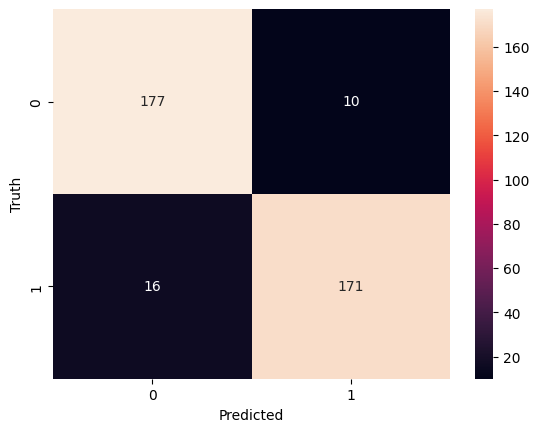

In [49]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       187
           1       0.94      0.91      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [51]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 1s/step


array([[0.6693969 ],
       [0.79555887],
       [0.7639292 ],
       [0.19179046],
       [0.09584168]], dtype=float32)